<a href="https://colab.research.google.com/github/mAlwardat/synthetic-photometry/blob/main/2025_03_22_Orbit_RV_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the input file name (including extension, e.g., 'MLR224.inp'): GL765_Test.inp
Position measures: 11
RV measures: 44, 44
Fitting 10 elements
CHI2/N: [np.float64(0.2956018729804931), np.float64(0.35493060124648435), np.float64(0.9503349861978164), np.float64(1.2666633406877625)]
RMS (Theta, rho, RV1, RV2): [np.float64(5.574638400476322), np.float64(0.00677110893411936), np.float64(0.4681357580814682), np.float64(0.657345144389249)]


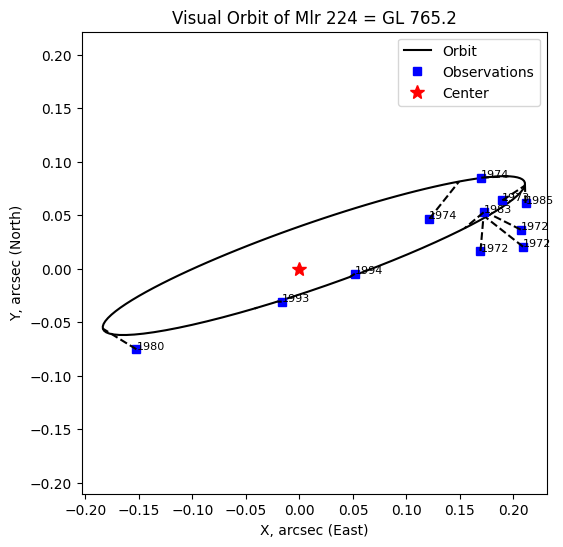

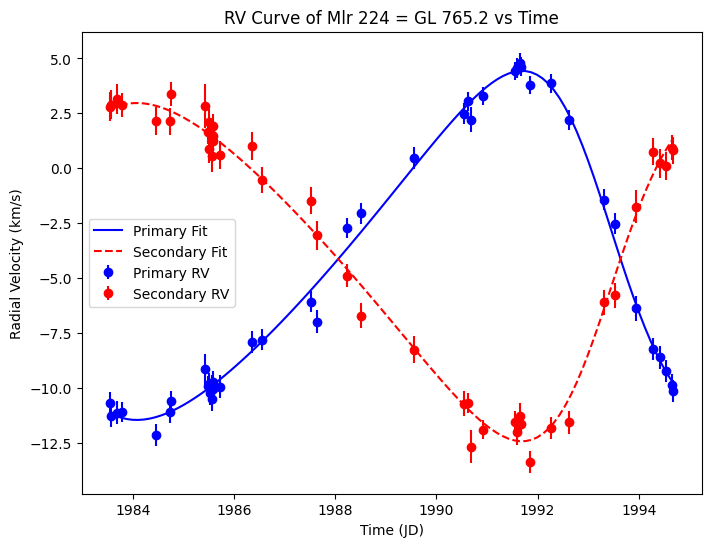

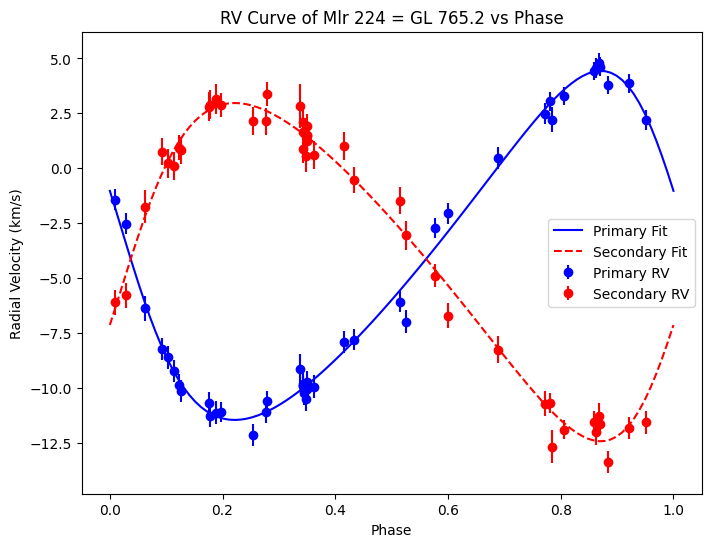

Results saved to GL765_Test_output.csv
Total system mass: 0.450 solar masses


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd
import os

# Global variables
class OrbitData:
    def __init__(self):
        self.el = np.zeros(10)  # [P, T, e, a, W, w, i, K1, K2, V0]
        self.elerr = np.zeros(10)
        self.fixel = np.ones(10, dtype=int)
        self.elname = ['P', 'T', 'e', 'a', 'W', 'w', 'i', 'K1', 'K2', 'V0']
        self.pos = None
        self.rv1 = None
        self.rv2 = None
        self.obj = {'name': '', 'radeg': 0.0, 'dedeg': 0.0, 'npos': 0, 'nrv1': 0, 'nrv2': 0,
                    'rms': np.zeros(4), 'chi2n': np.zeros(4), 'chi2': 0.0, 'fname': '',
                    'parallax': 0.0}
        self.graph = {'mode': 0}
        self.x = None
        self.y = None
        self.x2 = None
        self.y2 = None

orb = OrbitData()

# Ephemeris calculation
def eph(el, t, rho=False, rv=False):
    n = len(t)
    res = np.zeros((n, 2), dtype=float)
    pi2 = 2 * np.pi
    gr = 180 / np.pi

    P, T, SF, a, W, w, i, K1, K2, V0 = el
    CF2 = 1 - SF**2
    CF = np.sqrt(CF2)
    EC = np.sqrt((1 + SF) / (1 - SF))
    CWW = np.cos(W / gr)
    SWW = np.sin(W / gr)
    CW = np.cos(w / gr)
    SW = np.sin(w / gr)
    CI = np.cos(i / gr)
    SI = np.sin(i / gr)

    if rv:
        for i in range(n):
            dt = t[i] - T
            phase = (dt / P) % 1
            if phase < 0:
                phase += 1
            ANM = phase * pi2
            E = ANM
            E1 = E + (ANM + SF * np.sin(E) - E) / (1 - SF * np.cos(E))
            while abs(E1 - E) > 1e-5:
                E = E1
                E1 = E + (ANM + SF * np.sin(E) - E) / (1 - SF * np.cos(E))
            V = 2 * np.arctan(EC * np.tan(E1 / 2))
            U = V + w / gr
            CU = np.cos(U)
            A1 = SF * CW + CU
            res[i, 0] = V0 + K1 * A1
            res[i, 1] = V0 - K2 * A1
    else:
        AA = a * (CW * CWW - SW * SWW * CI)
        BB = a * (CW * SWW + SW * CWW * CI)
        FF = a * (-SW * CWW - CW * SWW * CI)
        GG = a * (-SW * SWW + CW * CWW * CI)
        for i in range(n):
            dt = t[i] - T
            phase = (dt / P) % 1
            if phase < 0:
                phase += 1
            ANM = phase * pi2
            E = ANM
            E1 = E + (ANM + SF * np.sin(E) - E) / (1 - SF * np.cos(E))
            while abs(E1 - E) > 1e-5:
                E = E1
                E1 = E + (ANM + SF * np.sin(E) - E) / (1 - SF * np.cos(E))
            V = 2 * np.arctan(EC * np.tan(E1 / 2))
            CV = np.cos(V)
            R = CF2 / (1 + SF * CV)
            X = R * CV
            Y = R * np.sin(V)
            res[i, 0] = AA * X + FF * Y
            res[i, 1] = BB * X + GG * Y

    if rho:
        rho_vals = np.sqrt(res[:, 0]**2 + res[:, 1]**2)
        theta = np.arctan2(res[:, 1], res[:, 0]) * 180 / np.pi
        theta = (theta + 360) % 360
        res[:, 0] = theta
        res[:, 1] = rho_vals

    return res

# Coordinate parsing
def getcoord(s):
    l = s.find('.')
    deg = int(s[:l]) if l > 0 else int(s)
    min_part = float(s[l:]) if l > 0 else 0
    res = abs(deg) + min_part
    if float(s) < 0:
        res = -res
    return res

# Time correction
def correct(data, t0):
    time = data[:, 0]
    for i in range(len(time)):
        if time[i] < 3000 and t0 > 3000:
            data[i, 0] = 365.242198781 * (time[i] - 1900) + 15020.31352
        elif time[i] > 3000 and t0 < 3000:
            data[i, 0] = 1900 + (time[i] - 15020.31352) / 365.242198781

# Read input file
def readinp(fname):
    global orb
    orb.el = np.zeros(10)
    orb.fixel = np.ones(10, dtype=int)
    nmax = 500
    orb.pos = np.zeros((nmax, 6))
    orb.rv1 = np.zeros((nmax, 3))
    orb.rv2 = np.zeros((nmax, 3))
    orb.obj['fname'] = fname

    if not os.path.exists(fname):
        print(f"File {fname} not found, exiting")
        orb.obj['fname'] = ''
        return

    with open(fname, 'r') as f:
        lines = f.readlines()

    kpos = 0
    krv1 = 0
    krv2 = 0
    for i, line in enumerate(lines):
        line = line.strip()
        if line.startswith('C'):
            continue
        fix = 0 if line.startswith('*') else 1
        parts = line.split()
        if not parts:
            continue
        ind = -1
        if parts[0] == 'Object:':
            orb.obj['name'] = ' '.join(parts[1:])
        elif parts[0] == 'R.A.:':
            orb.obj['radeg'] = 15 * getcoord(parts[1])
        elif parts[0] == 'Dec:':
            orb.obj['dedeg'] = getcoord(parts[1])
        elif parts[0] == 'Parallax:':
            orb.obj['parallax'] = float(parts[1])
        elif parts[0] in orb.elname:
            ind = orb.elname.index(parts[0])
            orb.el[ind] = float(parts[1])
            orb.fixel[ind] = fix
        elif 'I1' in line:
            orb.pos[kpos, 0:4] = [float(p) for p in parts[0:4]]
            kpos += 1
        elif 'Va' in line and len(parts) >= 3:
            orb.rv1[krv1, 0:3] = [float(p) for p in parts[0:3]]
            krv1 += 1
        elif 'Vb' in line and len(parts) >= 3:
            orb.rv2[krv2, 0:3] = [float(p) for p in parts[0:3]]
            krv2 += 1

    orb.pos = orb.pos[:kpos, :] if kpos > 0 else np.array([])
    orb.rv1 = orb.rv1[:krv1, :] if krv1 > 0 else np.array([])
    orb.rv2 = orb.rv2[:krv2, :] if krv2 > 0 else np.array([])

    if kpos > 0:
        correct(orb.pos, orb.el[1])
    if krv1 > 0:
        correct(orb.rv1, orb.el[1])
    if krv2 > 0:
        correct(orb.rv2, orb.el[1])

    print(f"Position measures: {kpos}")
    print(f"RV measures: {krv1}, {krv2}")
    orb.obj['npos'] = kpos
    orb.obj['nrv1'] = krv1
    orb.obj['nrv2'] = krv2

    orb.elerr = np.zeros(10)
    orb.graph['mode'] = 1 if (krv1 > 0 or krv2 > 0) else 0

# Orbit plotting
def orbplot(ps=False):
    global orb
    name = orb.obj['fname'].split('.')[0]

    # Visual orbit plot
    if orb.obj['npos'] > 0:
        plt.figure(figsize=(6, 6))
        time = np.linspace(0, orb.el[0], 100) + orb.el[1]
        xye = eph(orb.el, time)
        gr = 180 / np.pi
        xobs = -orb.pos[:, 2] * np.sin(orb.pos[:, 1] / gr)
        yobs = orb.pos[:, 2] * np.cos(orb.pos[:, 1] / gr)
        xy0 = eph(orb.el, orb.pos[:, 0])

        plt.plot(-xye[:, 1], xye[:, 0], 'k-', label='Orbit')
        plt.plot(xobs, yobs, 'bs', label='Observations')
        for i in range(len(xobs)):
            plt.plot([xobs[i], -xy0[i, 1]], [yobs[i], xy0[i, 0]], 'k--')
            year = int(round(orb.pos[i, 0]))
            plt.text(xobs[i], yobs[i], str(year), fontsize=8)
        plt.plot([0], [0], 'r*', markersize=10, label='Center')
        plt.xlabel('X, arcsec (East)')
        plt.ylabel('Y, arcsec (North)')
        plt.title(f"Visual Orbit of {orb.obj['name']}")
        plt.axis('equal')
        plt.legend()
        if ps:
            plt.savefig(f"{name}_POS.png")
        else:
            plt.show()

    # RV plot vs time
    if orb.obj['nrv1'] > 0 or orb.obj['nrv2'] > 0:
        plt.figure(figsize=(8, 6))
        t = np.linspace(min(np.concatenate([orb.rv1[:, 0] if orb.obj['nrv1'] > 0 else np.array([]),
                                           orb.rv2[:, 0] if orb.obj['nrv2'] > 0 else np.array([])])),
                       max(np.concatenate([orb.rv1[:, 0] if orb.obj['nrv1'] > 0 else np.array([]),
                                           orb.rv2[:, 0] if orb.obj['nrv2'] > 0 else np.array([])])),
                       100)
        rv = eph(orb.el, t, rv=True)

        if orb.obj['nrv1'] > 0:
            plt.errorbar(orb.rv1[:, 0], orb.rv1[:, 1], yerr=orb.rv1[:, 2], fmt='bo',
                        label='Primary RV', zorder=1)
        if orb.obj['nrv2'] > 0:
            plt.errorbar(orb.rv2[:, 0], orb.rv2[:, 1], yerr=orb.rv2[:, 2], fmt='ro',
                        label='Secondary RV', zorder=1)

        if orb.obj['nrv1'] > 0:
            plt.plot(t, rv[:, 0], 'b-', label='Primary Fit', zorder=2)
        if orb.obj['nrv2'] > 0:
            plt.plot(t, rv[:, 1], 'r--', label='Secondary Fit', zorder=2)

        plt.xlabel('Time (JD)')
        plt.ylabel('Radial Velocity (km/s)')
        plt.title(f"RV Curve of {orb.obj['name']} vs Time")
        plt.legend()
        if ps:
            plt.savefig(f"{name}_RV_time.png")
        else:
            plt.show()

    # RV plot vs phase
    if orb.obj['nrv1'] > 0 or orb.obj['nrv2'] > 0:
        plt.figure(figsize=(8, 6))
        t_phase = np.linspace(0, orb.el[0], 100) + orb.el[1]
        rv = eph(orb.el, t_phase, rv=True)
        phases = np.linspace(0, 1, 100)

        # Calculate phases for observations
        if orb.obj['nrv1'] > 0:
            phase1 = ((orb.rv1[:, 0] - orb.el[1]) / orb.el[0]) % 1
            phase1[phase1 < 0] += 1
            plt.errorbar(phase1, orb.rv1[:, 1], yerr=orb.rv1[:, 2], fmt='bo',
                        label='Primary RV', zorder=1)
        if orb.obj['nrv2'] > 0:
            phase2 = ((orb.rv2[:, 0] - orb.el[1]) / orb.el[0]) % 1
            phase2[phase2 < 0] += 1
            plt.errorbar(phase2, orb.rv2[:, 1], yerr=orb.rv2[:, 2], fmt='ro',
                        label='Secondary RV', zorder=1)

        if orb.obj['nrv1'] > 0:
            plt.plot(phases, rv[:, 0], 'b-', label='Primary Fit', zorder=2)
        if orb.obj['nrv2'] > 0:
            plt.plot(phases, rv[:, 1], 'r--', label='Secondary Fit', zorder=2)

        plt.xlabel('Phase')
        plt.ylabel('Radial Velocity (km/s)')
        plt.title(f"RV Curve of {orb.obj['name']} vs Phase")
        plt.legend()
        if ps:
            plt.savefig(f"{name}_RV_phase.png")
        else:
            plt.show()

# Fit orbital elements
def alleph(params, i):
    global orb
    selfit = np.where(orb.fixel > 0)[0]
    el0 = orb.el.copy()
    el0[selfit] = params
    e = 0.01
    del_vals = [e * el0[0], e * el0[0], e, e * el0[3], 1, 1, 1, e * el0[7], e * el0[8], e * el0[7]]

    if i < 2 * orb.obj['npos']:
        j = 1 if i >= orb.obj['npos'] else 0
        time = orb.pos[i - j * orb.obj['npos'], 0]
        res = eph(el0, [time], rho=True)[0, j]
        deriv = np.zeros(10)
        for k in range(10):
            if orb.fixel[k] > 0:
                el1 = el0.copy()
                el1[k] += del_vals[k]
                deriv[k] = (eph(el1, [time], rho=True)[0, j] - res) / del_vals[k]
        return np.concatenate([[res], deriv[selfit]])
    elif i < 2 * orb.obj['npos'] + orb.obj['nrv1']:
        time = orb.rv1[i - 2 * orb.obj['npos'], 0]
        res = eph(el0, [time], rv=True)[0, 0]
        deriv = np.zeros(10)
        for k in range(10):
            if orb.fixel[k] > 0:
                el1 = el0.copy()
                el1[k] += del_vals[k]
                deriv[k] = (eph(el1, [time], rv=True)[0, 0] - res) / del_vals[k]
        return np.concatenate([[res], deriv[selfit]])
    elif i < 2 * orb.obj['npos'] + orb.obj['nrv1'] + orb.obj['nrv2']:
        time = orb.rv2[i - 2 * orb.obj['npos'] - orb.obj['nrv1'], 0]
        res = eph(el0, [time], rv=True)[0, 1]
        deriv = np.zeros(10)
        for k in range(10):
            if orb.fixel[k] > 0:
                el1 = el0.copy()
                el1[k] += del_vals[k]
                deriv[k] = (eph(el1, [time], rv=True)[0, 1] - res) / del_vals[k]
        return np.concatenate([[res], deriv[selfit]])
    return np.zeros(len(selfit) + 1)

def fitorb(rms_only=False):
    global orb
    npos = orb.obj['npos']
    nrv1 = orb.obj['nrv1']
    nrv2 = orb.obj['nrv2']
    n = 2 * npos + nrv1 + nrv2
    yy = np.zeros(n)
    err = np.zeros(n)

    if npos > 0:
        yy[:npos] = orb.pos[:, 1]
        err[:npos] = orb.pos[:, 3] / orb.pos[:, 2] * 180 / np.pi
        yy[npos:2 * npos] = orb.pos[:, 2]
        err[npos:2 * npos] = orb.pos[:, 3]
    if nrv1 > 0:
        yy[2 * npos:2 * npos + nrv1] = orb.rv1[:, 1]
        err[2 * npos:2 * npos + nrv1] = orb.rv1[:, 2]
    if nrv2 > 0:
        yy[2 * npos + nrv1:] = orb.rv2[:, 1]
        err[2 * npos + nrv1:] = orb.rv2[:, 2]

    selfit = np.where(orb.fixel > 0)[0]
    print(f"Fitting {len(selfit)} elements")
    par = orb.el[selfit]

    def residuals(params):
        y1 = np.array([alleph(params, i)[0] for i in range(n)])
        return (yy - y1) / err

    if rms_only:
        y1 = np.array([alleph(par, i)[0] for i in range(n)])
    else:
        result = least_squares(residuals, par, method='lm', max_nfev=100)
        par = result.x
        y1 = yy - result.fun * err
        orb.el[selfit] = par
        orb.elerr[selfit] = np.sqrt(np.diag(result.jac.T @ result.jac) * np.var(result.fun))

    wt = 1 / err**2
    resid2 = (yy - y1)**2 * wt
    nmin = [0, npos, 2 * npos, 2 * npos + nrv1]
    nmax = [npos, 2 * npos, 2 * npos + nrv1, n]
    ndat = [nmax[i] - nmin[i] for i in range(4)]
    sd = [np.sum(resid2[nmin[j]:nmax[j]]) if ndat[j] > 0 else 0 for j in range(4)]
    wsum = [np.sum(wt[nmin[j]:nmax[j]]) if ndat[j] > 0 else 0 for j in range(4)]
    normchi2 = [sd[j] / ndat[j] if ndat[j] > 0 else 0 for j in range(4)]
    wrms = [np.sqrt(sd[j] / wsum[j]) if wsum[j] > 0 else 0 for j in range(4)]

    print(f"CHI2/N: {normchi2}")
    print(f"RMS (Theta, rho, RV1, RV2): {wrms}")
    orb.obj['rms'] = wrms
    orb.obj['chi2n'] = normchi2
    if not rms_only:
        orb.obj['chi2'] = np.sum((yy - y1)**2 / err**2)
        orbplot()

    return yy, y1

# Calculate total mass
def calculate_total_mass(P, a, parallax):
    if parallax <= 0:
        return 0.0
    distance_pc = 1000.0 / parallax
    a_au = a * distance_pc
    total_mass = (a_au**3) / (P**2)
    return total_mass

# Save results
def orbsave():
    global orb
    name = orb.obj['fname'].split('.')[0]
    outfile = f"{name}_output.csv"

    elements_data = {
        'Parameter': orb.elname,
        'Value': orb.el,
        'Error': orb.elerr,
        'Fixed': orb.fixel
    }
    elements_df = pd.DataFrame(elements_data)

    if orb.obj['npos'] > 0:
        res = eph(orb.el, orb.pos[:, 0], rho=True)
        pos_data = {
            'Time': orb.pos[:, 0],
            'PA_Obs': orb.pos[:, 1],
            'Rho_Obs': orb.pos[:, 2],
            'Err': orb.pos[:, 3],
            'PA_Fit': res[:, 0],
            'Rho_Fit': res[:, 1]
        }
        pos_df = pd.DataFrame(pos_data)
    else:
        pos_df = pd.DataFrame()

    if orb.obj['nrv1'] > 0:
        rv1_fit = eph(orb.el, orb.rv1[:, 0], rv=True)[:, 0]
        rv1_data = {
            'Time': orb.rv1[:, 0],
            'RV_Obs': orb.rv1[:, 1],
            'Err': orb.rv1[:, 2],
            'RV_Fit': rv1_fit
        }
        rv1_df = pd.DataFrame(rv1_data)
    else:
        rv1_df = pd.DataFrame()

    if orb.obj['nrv2'] > 0:
        rv2_fit = eph(orb.el, orb.rv2[:, 0], rv=True)[:, 1]
        rv2_data = {
            'Time': orb.rv2[:, 0],
            'RV_Obs': orb.rv2[:, 1],
            'Err': orb.rv2[:, 2],
            'RV_Fit': rv2_fit
        }
        rv2_df = pd.DataFrame(rv2_data)
    else:
        rv2_df = pd.DataFrame()

    total_mass = calculate_total_mass(orb.el[0], orb.el[3], orb.obj['parallax'])
    stats_data = {
        'Metric': ['CHI2', 'CHI2/N_Theta', 'CHI2/N_Rho', 'CHI2/N_RV1', 'CHI2/N_RV2',
                  'RMS_Theta', 'RMS_Rho', 'RMS_RV1', 'RMS_RV2', 'Parallax_mas', 'Total_Mass_Msun'],
        'Value': [orb.obj['chi2'], orb.obj['chi2n'][0], orb.obj['chi2n'][1], orb.obj['chi2n'][2],
                 orb.obj['chi2n'][3], orb.obj['rms'][0], orb.obj['rms'][1], orb.obj['rms'][2],
                 orb.obj['rms'][3], orb.obj['parallax'], total_mass]
    }
    stats_df = pd.DataFrame(stats_data)

    with open(outfile, 'w') as f:
        f.write(f"# Object: {orb.obj['name']}\n")
        f.write(f"# RA: {orb.obj['radeg']/15:.6f}\n")
        f.write(f"# Dec: {orb.obj['dedeg']:.6f}\n")
        f.write(f"# Parallax (mas): {orb.obj['parallax']:.6f}\n")
        f.write("\n# Orbital Elements\n")
        elements_df.to_csv(f, index=False)
        if not pos_df.empty:
            f.write("\n# Position Measurements\n")
            pos_df.to_csv(f, index=False)
        if not rv1_df.empty:
            f.write("\n# Primary RV Measurements\n")
            rv1_df.to_csv(f, index=False)
        if not rv2_df.empty:
            f.write("\n# Secondary RV Measurements\n")
            rv2_df.to_csv(f, index=False)
        f.write("\n# Statistics\n")
        stats_df.to_csv(f, index=False)

    print(f"Results saved to {outfile}")
    if orb.obj['parallax'] > 0:
        print(f"Total system mass: {total_mass:.3f} solar masses")
    else:
        print("Parallax not provided, cannot calculate total mass")

# Main execution
if __name__ == "__main__":
    filename = input("Enter the input file name (including extension, e.g., 'MLR224.inp'): ")
    readinp(filename)
    if orb.obj['fname']:
        fitorb()
        orbsave()